# Прогноз цены пальмового масла_LSTM_25.06.2024

## Содержание

* [Описание механизма работы модели](#Описание)
* [Импорт библиотек Python и загрузка данных](#Импорт)
* [Предобработка данных](#Предобработка)
* [Прогноз цены пальмового масла](#Прогноз)
    * [Подготовка данных](#Прогноз_подготовка)
    * [Построение модели нейронной сети LSTM](#Прогноз_LSTM)
    * [Тестирование качества модели](#Прогноз_тестирование)
    * [Построение прогноза на будущий период](#Прогноз_10дней)
    * [Сохранение параметров модели и экспорт прогноза на ПК](#Прогноз_сохранение)

## Описание механизма работы модели <a class = 'anchor' id = 'Описание'></a>

## Импорт библиотек Python и загрузка данных <a class = 'anchor' id = 'Импорт'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * с методами классического машинного обучения;
    * для построения нейронной сети;
2. Загрузка данных в рабочую среду Jupyter Notebook. Инициализация переменной **df** для хранения загруженного датасета;
3. Вывод на экран параметров датасета:
    * Список названий столбцов;
    * Количество строк, содержащихся в наборе данных;
    * Количество столбцов, содержащихся в наборе данных.

In [6]:
# импорт библиотек для манипулирования данными
import pandas as pd
import numpy as np
from datetime import datetime

# импорт библиотек визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# импорт методов классического машинного обучения
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# импорт методов построения нейронных сетей
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

C:\Users\k.storozhuk\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# загрузка данных из директории хранения на ПК
df = pd.read_excel('~/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/datasets/dataset_po modeling.xlsx')

In [8]:
# вывод на экран списка названий столбцов и параметров датасета

print('Список столбцов в загруженном наборе данных')
for i in list(df.columns):
    print('*', i)
print()
print('Количество столбцов в наборе данных', df.shape[1])
print('Количество строк в наборе данных', df.shape[0])

Список столбцов в загруженном наборе данных
* date
* Soybean oil_Rotterdam
* Soybean oil_Brazil
* Soybean oil_Argentina
* Soybean seed_Brazil
* Rapeseed oil_Rotterdam
* Rupees/$
* Yuan/$
* Euro/$
* Ruble/$
* Ringgit/$
* Oil_Brent
* Oil_Urals
* Palm oil_crude
* Palm oil_RBD
* Palm oil_Argentina
* Biodiesel_USA
* mean_temp
* mean_pres
* mean_humid

Количество столбцов в наборе данных 20
Количество строк в наборе данных 4984


## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Понижение регистра заголовков и приведение их к единому стилю
2. Контрольная обработка типов данных в столбцах, последующих на этап моделирования:
    * Для столбца **date** - тип **datetime**;
    * Для столбца **palm oil_rbd** - тип **float**
3. Сортировка значений в наборе данных по столбцу **date** в порядке возрастания;
4. Отбор столбцов **date** и **palm oil_rbd** - перезапись переменной **df**;
5. Инициализация переменной **border_date** для хранения даты последнего пустого значения в столбце **palm oil_rbd**. Фильтрация набора данных по этой переменной - ликвидация пропущенных значений.

In [11]:
# приводим заголовки набора данных к snake_case
df.columns = df.columns.str.lower()

# контрольно обработаем данные с датой и ценой пальмового масла - приведем их к соответствующим типам
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['palm oil_rbd'] = df['palm oil_rbd'].astype('float')

# отсортируем датасет по возрастанию даты
df = df.sort_values(by = 'date', ascending = True)

# отберем в итоговый набор два столбца для дальнейшего анализа и построения нейронной сети
df = df[['date', 'palm oil_rbd']]

# выведем на экран результат преобразований
df.head()

,date,palm oil_rbd
0,2011-01-20,NaN
1,2011-01-21,1260.0
2,2011-01-22,1260.0
3,2011-01-23,1260.0
4,2011-01-24,1267.5


In [12]:
# поиск даты последнего пустого значения из столбца Palm Oil_RBD
border_date = df[df['palm oil_rbd'].isna() == True]['date'].to_list()[-1]

# отфильтровываем набор данных по дате
df = df[df['date'] > border_date]

print('Количество строк в "очищенном" наборе данных', df.shape[0])
print('Минимальная дата в "очищенном" наборе данных', min(df['date']))
print('Максимальная дата в "очищенном" наборе данных', max(df['date']))

Количество строк в "очищенном" наборе данных 4983
Минимальная дата в "очищенном" наборе данных 2011-01-21 00:00:00
Максимальная дата в "очищенном" наборе данных 2024-09-11 00:00:00


## Прогноз цены пальмового масла <a class = 'anchor' id = 'Прогноз'></a>

### Подготовка данных <a class = 'anchor' id = 'Прогноз_подготовка'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Преобразование значений индексов строк - каждая строка обозначается датой;
2. Инициализация переменной **num_shape**, которая является границой раздела общего набора данных на обучающую и тестовую выборки;
3. Инициализация переменных **train** и **test**, хранящие обучающий и тестовый набор с данными соответственно;
4. Инициализация объекта масштабирования данных **sc**;
5. Инициализация переменной **train_sc**, в которой хранятся масштабированные значения цены пальмового масла (в диапазоне от 0 до 1) тестового набора;
6. Инициализация переменных **X_train** и **y_train**, в которых хранятся окна значений (60 значений) и последующая цена (61-е значение) соответственно.

In [16]:
# формируем индексы набора данных из столбца с датой
df = df.set_index('date')

# устанавливаем границу раздела обучающей и тестовой выборки - 95% от общего набора отводится на обучение нейронной сети
num_shape = int(df.shape[0] * 0.95)

# делим общий набор на обучающий и тестовый
train = df.iloc[:num_shape, :].values
test = df.iloc[num_shape:, :].values

In [17]:
# инициализируем объект масштабирования
sc = MinMaxScaler(feature_range = (0, 1))
train_sc = sc.fit_transform(train)

In [18]:
# формируем область признаков и вектор целевой переменной
X_train = [] # список для хранения каждого из окон
y_train = [] # каждое последующее значение после окна - то, которое необходимо спрогнозировать

window = 50 # формируем окна из 50 значений

for i in range(window, num_shape):
    X_train_ = np.reshape(train_sc[i - window : i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_sc[i, 0])

X_train = np.stack(X_train)
y_train = np.stack(y_train)

### Построение модели нейронной сети LSTM <a class = 'anchor' id = 'Прогноз_LSTM'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Инициализация объекта модели рекуррентной нейронной сети:
    * Определение количества слоев модели;
    * Определение количества нейронов в слое;
    * Определение доли информации, которую необходимо "забыть" на каждом уровне нейронной сети.
2. Определение гиперпараметров нейронной сети, которые будут служить критериями качества обучения и построения прогноза:
    * Ввод критерия оптимизации;
    * Обозначение функции ошибки;
3. Обучение модели на тестовом наборе данных.

In [21]:
# # строим нейронную сеть
# modelLSTM = Sequential() # инициализация объекта реккурентной нейронной сети
# # 
# modelLSTM.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
# modelLSTM.add(Dropout(0.2))
# # 
# modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
# modelLSTM.add(Dropout(0.2))
# # 
# modelLSTM.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
# modelLSTM.add(Dropout(0.2))
# # 
# modelLSTM.add(LSTM(units = 120, activation = 'relu'))
# modelLSTM.add(Dropout(0.2))
# # 
# modelLSTM.add(Dense(units = 1))
# # 
# modelLSTM.summary()

In [22]:
# # обучение нейронной сети
# modelLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
# modelLSTM.fit(X_train, y_train, epochs = 400, batch_size = 32)

### Тестирование качества модели <a class = 'anchor' id = 'Прогноз_тестирование'></a>

In [24]:
# импортируем объект модели нейронной сети LSTM
modelLSTM = load_model("C:/Users/k.storozhuk/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/models_params/lstm_params.keras")

Данный блок характеризуется следующими последовательными действиями:
1. Формирование тестового набора данных через цикл с использованием фиксированного показателя окна значений (**window**) - инициализация переменной **X_test**;
2. Инициализация переменной **predict** - построение прогноза на тестовом наборе данных и сохранение результатов в переменную;
3. Преобразование значений прогноза из диапазона (0, 1) к формату цены пальмового масла ($/т);
4. Расчет показателей качества модели:
    * MAE - средняя абсолютная ошибка (отклонение - долл/т);
    * MSE - среднеквадратическая ошибка (отклонение - долл^2/т);
    * RMSE - корень из среднеквадратической ошибки (отклонение - долл/т);
5. Построение визуализации фактических и прогнозных значений тестового набора данных. Визуальная проверка качества обучения модели нейронной сети.

In [26]:
# прогноз на тестовом наборе данных
df_volume = np.vstack((train, test))
inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i - window : i, 0], (window, 1))
    X_test.append(X_test_)

X_test = np.stack(X_test)

In [27]:
predict = modelLSTM.predict(X_test)
predict = sc.inverse_transform(predict)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [28]:
# проверяем качество модели на расчете ошибок
print('Средняя абсолютная ошибка MAE:', mean_absolute_error(test, predict))
print('Средняя квадратическая ошибка MSE:', mean_squared_error(test, predict))
print('Корень из среднеквадратической ошибки RMSE:', np.sqrt(mean_squared_error(test, predict)))

Средняя абсолютная ошибка MAE: 74.2843349609375
Средняя квадратическая ошибка MSE: 5979.203021337956
Корень из среднеквадратической ошибки RMSE: 77.3253064742582


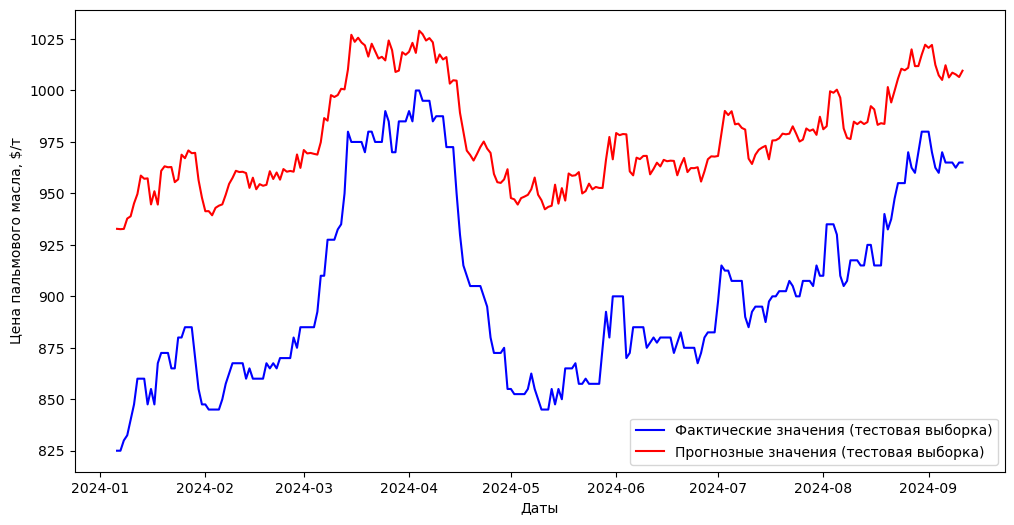

In [29]:
# преобразуем array в датафрейм
predict_df = pd.DataFrame(data = predict, index = df.iloc[num_shape:, :].index)

# строим график прогноза
plt.figure(figsize = (12, 6))
plt.plot(df.iloc[num_shape:, :], c = 'blue', label = 'Фактические значения (тестовая выборка)')
plt.plot(predict_df, c = 'red', label = 'Прогнозные значения (тестовая выборка)')
plt.xlabel('Даты')
plt.ylabel('Цена пальмового масла, $/т')
plt.legend()
plt.show()

### Построение прогноза на будущий период <a class = 'anchor' id = 'Прогноз_10дней'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Формирование данных, подаваемых на вход модели:
     * Инициализация переменной **pred_** - стартовое значение цены пальмового масла для последующего прогноза;
     * Инициализация переменной **prediction_full** для хранения спрогнозированных значений;
     * Инициализация переменной **window** с перезаписью размера окна значений;
     * Инициализация переменной **df_copy** с сохранением значений исходного набора данных.
2. Реализация прогноза будущих значений через цикл;
3. Инициализация переменной **prediction_full_new** для хранения трансформированных значений, спрогнозированных моделью;
4. Инициализация переменной **date_range** для хранения значений дат для прогнозных значений цены пальмового масла;
5. Инициализация переменной **predictions_10days** для хранения датафрейма прогнозных значений;
6. Визуализация прогноза на графике;

In [32]:
# прогноз на 10 дней вперед

# задаем изначальные параметры для модели
pred_ = predict[-1].copy()
prediction_full = []
window = 50
df_copy = df.values

# цикл обучения и добавления в набор новых прогнозных значения
for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    df_volume_ = np.vstack((train_, test_))
    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1, 1)
    inputs_ = sc.transform(inputs_)
    X_test_2 = []
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k - window : k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelLSTM.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [33]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1, 1)))

In [34]:
date_range = pd.date_range(start = pd.to_datetime(max(df.index.date) + pd.DateOffset(days = 1)), end = pd.to_datetime(max(df.index.date) + pd.DateOffset(days = 10)))
date_range

DatetimeIndex(['2024-09-12', '2024-09-13', '2024-09-14', '2024-09-15',
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-21'],
              dtype='datetime64[ns]', freq='D')

In [35]:
predictions_10days = pd.DataFrame(data = np.array(prediction_full), index = date_range).rename(columns = {'0' : 'predicted_price'})

In [36]:
predictions_10days

,0
2024-09-12,1009.611694
2024-09-13,1009.611694
2024-09-14,1008.588684
2024-09-15,1002.726379
2024-09-16,986.774719
2024-09-17,1006.389771
2024-09-18,995.502502
2024-09-19,1007.465820
2024-09-20,997.082703
2024-09-21,1007.328186


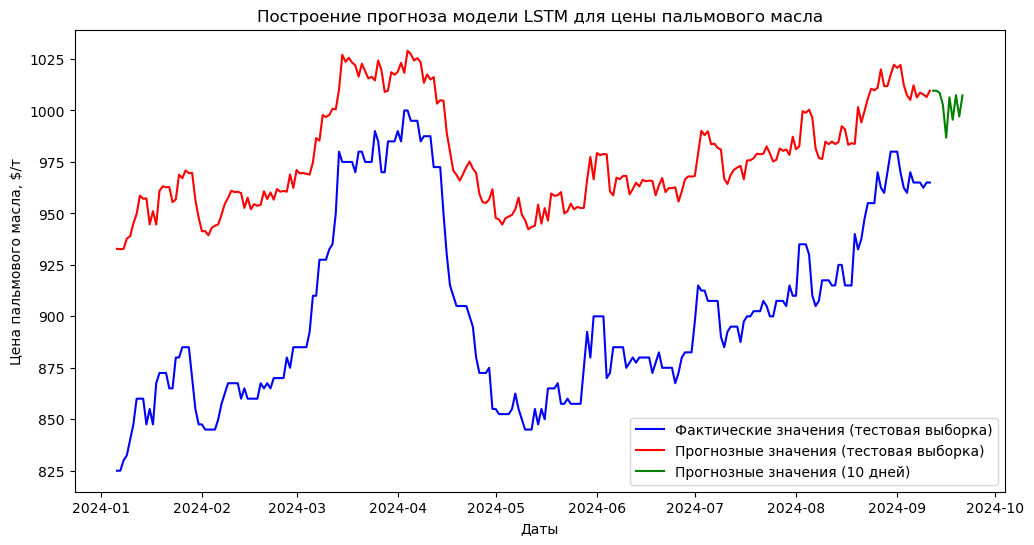

In [37]:
# строим график прогноза
plt.figure(figsize = (12, 6))
plt.plot(df.iloc[num_shape:, :], c = 'blue', label = 'Фактические значения (тестовая выборка)')
plt.plot(predict_df, c = 'red', label = 'Прогнозные значения (тестовая выборка)')
plt.plot(predictions_10days, c = 'green', label = 'Прогнозные значения (10 дней)')
plt.title('Построение прогноза модели LSTM для цены пальмового масла')
plt.xlabel('Даты')
plt.ylabel('Цена пальмового масла, $/т')
plt.legend()
plt.show()

### Сохранение параметров модели и экспорт прогноза на ПК <a class = 'anchor' id = 'Прогноз_сохранение'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Сохранение параметров модели в хранилище на ПК для последующего использования без предварительного обучения нейросети;
2. Сохранение результатов прогноза на ПК.

In [40]:
# сохранение параметров модели на ПК
modelLSTM.save('C:/Users/k.storozhuk/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/models_params/lstm_params.keras')

In [41]:
# формируем датафрейм прогноза из тестовой выборки и спрогнозированных будущих значений
lstm_predictions = pd.concat([predict_df, predictions_10days])

# сохраняем результаты прогноза на ПК
lstm_predictions.to_csv("C:/Users/k.storozhuk/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/data reports_from jupyter/lstm_predictions.csv")

In [42]:
# загрузка исторических данных
pred_point = pd.read_csv('~/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/prediction history/lstm_history.csv')

# соединяем историю и новые прогнозные значения
lstm_history = pd.concat([pred_point, predictions_10days])

# выгрузка истории прогнозов на ПК
lstm_history.to_csv('C:/Users/k.storozhuk/Desktop/МОИ РАБОТЫ/85. Построение модели прогнозирования цены пальмового масла_новая версия/prediction history/lstm_history.csv')